# Шаблон модели на LAMA

## 0. Предустановка

### 0.0. Установка LightAutoML и библиотек

In [1]:
# !pip install pyod
# !pip install ruptures
# !pip install ipywidgets
# !pip install pandas-ta
# !pip install -U lightautoml==0.3.8b1
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install sklearn
# !pip install statsmodels
# !pip install moexalgo

### 0.1. Импорт библиотек

In [2]:
# Standard python libraries
import os
import datetime

# Installed libraries
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import pickle
import requests
import pyod

# Imports from our package
from lightautoml.tasks import Task
from lightautoml.addons.autots.base import AutoTS
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.automl.base import AutoML
from lightautoml.ml_algo.boost_cb import BoostCB
from lightautoml.ml_algo.linear_sklearn import LinearLBFGS
from lightautoml.pipelines.features.lgb_pipeline import LGBSeqSimpleFeatures
from lightautoml.pipelines.features.linear_pipeline import LinearTrendFeatures
from lightautoml.pipelines.ml.base import MLPipeline
from lightautoml.reader.base import DictToPandasSeqReader
from lightautoml.automl.blend import WeightedBlender
from lightautoml.ml_algo.random_forest import RandomForestSklearn

from moexalgo import Market, Ticker

# Disable warnings
import warnings
warnings.filterwarnings("ignore")

'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'nltk' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependecy package 'transformers' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


C:\Users\tdall\anaconda3\envs\py39\lib\site-packages\lightautoml\ml_algo\dl_model.py:41: UserWarning: 'transformers' - package isn't installed
  warnings.warn("'transformers' - package isn't installed")
C:\Users\tdall\anaconda3\envs\py39\lib\site-packages\lightautoml\text\nn_model.py:22: UserWarning: 'transformers' - package isn't installed
  warnings.warn("'transformers' - package isn't installed")
C:\Users\tdall\anaconda3\envs\py39\lib\site-packages\lightautoml\text\dl_transformers.py:25: UserWarning: 'transformers' - package isn't installed
  warnings.warn("'transformers' - package isn't installed")


### 0.2. Константы и функции

Здесь мы настраиваем константы для использования в ядре:
- `HORIZON` - количество точек для прогноза 
- `TARGET_COLUMN` - 
имя целевого столбца в наборе данных
- `DATE_COLUMN` -
имя столбц с датойа в наборе данныхt

In [3]:
HORIZON = 1
TARGET_COLUMN = "close"
DATE_COLUMN = "date"
ID_COLUMN = 'id'
# path to Lib\site-packages\lightautoml\automl\presets\time_series_config.yml
PATH = r"C:\Users\tdall\anaconda3\envs\py39\Lib\site-packages\lightautoml\automl\presets\time_series_config.yml"

### 0.3. Загрузка данных

In [4]:
#Настройки
ticker_name = 'ALRS'
period = '1D'
date_from = '2007-07-20'
date_to = '2023-12-08'

In [5]:
# Акции
ticker = Ticker(ticker_name)

# Свечи по акциям за период. Период в минутах 1, 10, 60 или '1m', '10m', '1h', 'D', 'W', 'M', 'Q'; по умолчанию 60
df = ticker.candles(date=date_from, till_date=date_to, period=period)
print(type(df))

df.drop(['end'], axis=1, inplace=True)
df.rename(columns={"begin": "date"}, inplace=True)
df.tail(7)

[2023-12-09 23:15:26,422] (INFO): HTTP Request: GET https://iss.moex.com/iss/engines/stock/markets/shares/boards/TQBR/securities/columns.json "HTTP/1.1 200 OK"
[2023-12-09 23:15:26,761] (INFO): HTTP Request: GET https://iss.moex.com/iss/engines/stock/markets/shares/boards/TQBR/securities.json "HTTP/1.1 200 OK"
[2023-12-09 23:15:28,148] (INFO): HTTP Request: GET https://iss.moex.com/iss/engines/stock/markets/shares/boards/TQBR/securities/ALRS/candles.json?from=2007-07-20&till=2023-12-08&interval=24&start=0 "HTTP/1.1 200 OK"
[2023-12-09 23:15:28,493] (INFO): HTTP Request: GET https://iss.moex.com/iss/engines/stock/markets/shares/boards/TQBR/securities/ALRS/candles.json?from=2007-07-20&till=2023-12-08&interval=24&start=500 "HTTP/1.1 200 OK"
[2023-12-09 23:15:29,513] (INFO): HTTP Request: GET https://iss.moex.com/iss/engines/stock/markets/shares/boards/TQBR/securities/ALRS/candles.json?from=2007-07-20&till=2023-12-08&interval=24&start=1000 "HTTP/1.1 200 OK"
[2023-12-09 23:15:30,553] (INFO)

<class 'pandas.core.frame.DataFrame'>


,open,close,high,low,value,volume,date
2794,66.89,65.18,66.96,65.00,7.637310e+08,11644400.0,2023-11-30
2795,65.02,65.03,65.84,64.65,4.991263e+08,7657130.0,2023-12-01
2796,64.99,65.24,66.14,64.41,6.614267e+08,10096870.0,2023-12-04
2797,65.46,66.30,66.95,65.20,4.924046e+08,7464790.0,2023-12-05
2798,66.54,65.89,66.54,64.70,1.503751e+09,22882650.0,2023-12-06
2799,65.79,67.53,67.70,65.40,1.482841e+09,22203740.0,2023-12-07
2800,67.75,70.92,70.96,67.75,2.975284e+09,42841800.0,2023-12-08


In [6]:
# список доступных индикаторов
df.ta.indicators()

Pandas TA - Technical Analysis Indicators - v0.3.14b0
Total Indicators & Utilities: 205
Abbreviations:
    aberration, above, above_value, accbands, ad, adosc, adx, alma, amat, ao, aobv, apo, aroon, atr, bbands, below, below_value, bias, bop, brar, cci, cdl_pattern, cdl_z, cfo, cg, chop, cksp, cmf, cmo, coppock, cross, cross_value, cti, decay, decreasing, dema, dm, donchian, dpo, ebsw, efi, ema, entropy, eom, er, eri, fisher, fwma, ha, hilo, hl2, hlc3, hma, hwc, hwma, ichimoku, increasing, inertia, jma, kama, kc, kdj, kst, kurtosis, kvo, linreg, log_return, long_run, macd, mad, massi, mcgd, median, mfi, midpoint, midprice, mom, natr, nvi, obv, ohlc4, pdist, percent_return, pgo, ppo, psar, psl, pvi, pvo, pvol, pvr, pvt, pwma, qqe, qstick, quantile, rma, roc, rsi, rsx, rvgi, rvi, short_run, sinwma, skew, slope, sma, smi, squeeze, squeeze_pro, ssf, stc, stdev, stoch, stochrsi, supertrend, swma, t3, td_seq, tema, thermo, tos_stdevall, trima, trix, true_range, tsi, tsignals, ttm_trend, ui, 

In [7]:
# Построение стратегии анализа
MyStrategy = ta.Strategy(
    name="mystrat",
    ta=[
         {'kind': 'above_value', 'append': True},
         {'kind': 'accbands', 'append': True},
         {'kind': 'ad', 'append': True},
         {'kind': 'adosc', 'append': True},
         {'kind': 'adx', 'append': True},
         {'kind': 'alma', 'append': True},
         {'kind': 'amat', 'append': True},
         {'kind': 'ao', 'append': True},
         {'kind': 'aobv', 'append': True},
         {'kind': 'apo', 'append': True},
         {'kind': 'aroon', 'append': True},
         {'kind': 'atr', 'append': True},
         {'kind': 'bbands', 'append': True},
         {'kind': 'below', 'append': True},
         {'kind': 'below_value', 'append': True},
         {'kind': 'bias', 'append': True},
         {'kind': 'bop', 'append': True},
         {'kind': 'brar', 'append': True},
         {'kind': 'cci', 'append': True},
         {'kind': 'cdl_pattern', 'append': True},
         {'kind': 'cdl_z', 'append': True},
         {'kind': 'cfo', 'append': True},
         {'kind': 'cg', 'append': True},
         {'kind': 'chop', 'append': True},
         {'kind': 'cksp', 'append': True},
         {'kind': 'cmf', 'append': True},
         {'kind': 'cmo', 'append': True},
         {'kind': 'coppock', 'append': True},
         {'kind': 'cross', 'append': True},
         {'kind': 'cross_value', 'append': True},
         {'kind': 'cti', 'append': True},
         {'kind': 'decreasing', 'append': True},
         {'kind': 'dema', 'append': True},
         {'kind': 'dm', 'append': True},
         {'kind': 'donchian', 'append': True},
         {'kind': 'dpo', 'append': True},
         {'kind': 'efi', 'append': True},
         {'kind': 'ema', 'append': True},
         {'kind': 'entropy', 'append': True},
         {'kind': 'eom', 'append': True},
         {'kind': 'er', 'append': True},
         {'kind': 'eri', 'append': True},
         {'kind': 'fisher', 'append': True},
         {'kind': 'fwma', 'append': True},
         {'kind': 'hilo', 'append': True},
         {'kind': 'hl2', 'append': True},
         {'kind': 'hlc3', 'append': True},
         {'kind': 'hma', 'append': True},
         {'kind': 'hwma', 'append': True},
         {'kind': 'ichimoku', 'append': True},
         {'kind': 'increasing', 'append': True},
         {'kind': 'inertia', 'append': True},
         {'kind': 'kama', 'append': True},
         {'kind': 'kc', 'append': True},
         {'kind': 'kdj', 'append': True},
         {'kind': 'kst', 'append': True},
         {'kind': 'kurtosis', 'append': True},
         {'kind': 'kvo', 'append': True},
         {'kind': 'linreg', 'append': True},
         {'kind': 'log_return', 'append': True},
         {'kind': 'long_run', 'append': True},
         {'kind': 'macd', 'append': True},
         {'kind': 'mad', 'append': True},
         {'kind': 'massi', 'append': True},
         {'kind': 'mcgd', 'append': True},
         {'kind': 'median', 'append': True},
         {'kind': 'mfi', 'append': True},
         {'kind': 'midpoint', 'append': True},
         {'kind': 'midprice', 'append': True},
         {'kind': 'mom', 'append': True},
         {'kind': 'natr', 'append': True},
         {'kind': 'nvi', 'append': True},
         {'kind': 'obv', 'append': True},
         {'kind': 'ohlc4', 'append': True},
         {'kind': 'pdist', 'append': True},
         {'kind': 'percent_return', 'append': True},
         {'kind': 'pgo', 'append': True},
         {'kind': 'ppo', 'append': True},
         {'kind': 'psar', 'append': True},
         {'kind': 'psl', 'append': True},
         {'kind': 'pvi', 'append': True},
         {'kind': 'pvo', 'append': True},
         {'kind': 'pvol', 'append': True},
         {'kind': 'pvr', 'append': True},
         {'kind': 'pvt', 'append': True},
         {'kind': 'pwma', 'append': True},
         {'kind': 'qqe', 'append': True},
         {'kind': 'qstick', 'append': True},
         {'kind': 'quantile', 'append': True},
         {'kind': 'rma', 'append': True},
         {'kind': 'roc', 'append': True},
         {'kind': 'rsi', 'append': True},
         {'kind': 'rsx', 'append': True},
         {'kind': 'rvgi', 'append': True},
         {'kind': 'rvi', 'append': True},
         {'kind': 'short_run', 'append': True},
         {'kind': 'sinwma', 'append': True},
         {'kind': 'skew', 'append': True},
         {'kind': 'slope', 'append': True},
         {'kind': 'sma', 'append': True},
         {'kind': 'smi', 'append': True},
         {'kind': 'squeeze', 'append': True},
         {'kind': 'squeeze_pro', 'append': True},
         {'kind': 'ssf', 'append': True},
         {'kind': 'stdev', 'append': True},
         {'kind': 'stoch', 'append': True},
         {'kind': 'stochrsi', 'append': True},
         {'kind': 'supertrend', 'append': True},
         {'kind': 'swma', 'append': True},
         {'kind': 't3', 'append': True},
         {'kind': 'td_seq', 'append': True},
         {'kind': 'tema', 'append': True},
         {'kind': 'thermo', 'append': True},
         {'kind': 'tos_stdevall', 'append': True},
         {'kind': 'trima', 'append': True},
         {'kind': 'trix', 'append': True},
         {'kind': 'true_range', 'append': True},
         {'kind': 'tsi', 'append': True},
         {'kind': 'tsignals', 'append': True},
         {'kind': 'ttm_trend', 'append': True},
         {'kind': 'ui', 'append': True},
         {'kind': 'uo', 'append': True},
         {'kind': 'variance', 'append': True},
         {'kind': 'vhf', 'append': True},
         {'kind': 'vidya', 'append': True},
         {'kind': 'vortex', 'append': True},
         {'kind': 'vp', 'append': True},
         {'kind': 'vwma', 'append': True},
         {'kind': 'wcp', 'append': True},
         {'kind': 'willr', 'append': True},
         {'kind': 'wma', 'append': True},
         {'kind': 'xsignals', 'append': True},
         {'kind': 'zlma', 'append': True},
         {'kind': 'zscore', 'append': True}
     ]
)

try :
    df.ta.strategy(MyStrategy, append=True)
except:
    try:
        df.ta.strategy(MyStrategy, append=True)
    except:
        df.ta.strategy(MyStrategy, append=True)

In [8]:
# удалим колонки индикаторов с пропусками значений больше N
col_to_del = []

cols = list(df.columns)
for col in cols:
    if df[col].isnull().sum() > 100:
        col_to_del.append(col)

df.drop(col_to_del, axis=1, inplace=True)

col_to_del = []

cols = list(df.columns)
for col in cols:
    if df[col].iloc[-100:].isnull().sum() > 0:
        col_to_del.append(col)

df.drop(col_to_del, axis=1, inplace=True)

In [9]:
# Удалим строки с пустыми ячейками индикаторов
df = df.dropna()
df[DATE_COLUMN] = pd.to_datetime(df[DATE_COLUMN])
df.tail()

,open,close,high,low,value,volume,date,ACCBL_20,ACCBM_20,ACCBU_20,...,VHF_28,VIDYA_14,VTXP_14,VTXM_14,VWMA_10,WCP,WILLR_14,WMA_10,ZL_EMA_10,ZS_30
2796,64.99,65.24,66.14,64.41,6.614267e+08,10096870.0,2023-12-04,63.632890,67.4405,71.460390,...,0.386737,69.078168,0.883235,1.101772,66.024821,65.2575,-79.527559,65.726364,65.293289,-1.412649
2797,65.46,66.30,66.95,65.20,4.924046e+08,7464790.0,2023-12-05,63.305695,67.2360,71.358195,...,0.379827,68.980383,0.907331,1.107423,65.963591,66.1875,-55.032120,65.782727,65.398145,-0.902296
2798,66.54,65.89,66.54,64.70,1.503751e+09,22882650.0,2023-12-06,63.039287,66.9495,71.081787,...,0.372106,68.923214,0.907216,1.109185,65.917957,65.7550,-51.988636,65.778545,65.616664,-1.020395
2799,65.79,67.53,67.70,65.40,1.482841e+09,22203740.0,2023-12-07,62.622743,66.7580,71.025243,...,0.353541,68.905237,0.987903,0.968190,66.183696,67.0400,-5.397727,66.085455,66.419089,-0.231939
2800,67.75,70.92,70.96,67.75,2.975284e+09,42841800.0,2023-12-08,62.307621,66.7855,71.207621,...,0.299818,69.006031,1.060484,0.834677,67.422542,70.1375,-0.591716,66.983455,68.270164,1.340133


In [10]:
# Сделаем временной ряд непрерывным и смержим с датасетом
date = pd.DataFrame(pd.date_range(start=df.date.iloc[0], end=date_to), columns=['date'])
df = date.merge(df, how='left', on='date')

# Заполним пропуски
for col in df.columns:
    if col == 'date':
        continue
    df.fillna(method='ffill', inplace=True)

df.head()

,date,open,close,high,low,value,volume,ACCBL_20,ACCBM_20,ACCBU_20,...,VHF_28,VIDYA_14,VTXP_14,VTXM_14,VWMA_10,WCP,WILLR_14,WMA_10,ZL_EMA_10,ZS_30
0,2013-01-28,29.400,29.480,29.968,29.250,8847729.0,300800.0,27.673835,29.65105,31.602335,...,0.529391,28.358516,0.934662,1.139381,29.544895,29.5445,-59.276206,29.469745,29.351978,0.535112
1,2013-01-29,29.540,29.800,29.997,29.467,19961014.0,673200.0,27.790605,29.73480,31.669355,...,0.526796,28.377359,0.953342,1.042708,29.543647,29.7660,-45.965058,29.510764,29.515255,0.686528
2,2013-01-30,29.663,29.850,30.010,29.582,13019786.4,435000.0,28.029336,29.72730,31.490586,...,0.529213,28.404770,1.052855,1.025427,29.576257,29.8230,-43.885191,29.564509,29.712481,0.676887
3,2013-01-31,29.542,29.929,29.939,28.799,12372669.3,417000.0,27.975994,29.72835,31.484744,...,0.445324,28.440119,0.925085,0.958227,29.608531,29.6490,-40.599002,29.631709,29.833666,0.691138
4,2013-02-01,29.897,29.770,30.890,29.700,12768453.0,425400.0,27.903992,29.71440,31.597742,...,0.408481,28.446728,1.029293,0.872899,29.621743,30.0325,-47.212978,29.667564,29.874818,0.522903


### 0.4. Разделение данных на train и test

In [11]:
test_start = df[DATE_COLUMN].values[-HORIZON]  

train = df[df[DATE_COLUMN] < test_start].copy()
test = df[df[DATE_COLUMN] >= test_start].copy()

# 1. Определение задачи модели

## 1.1. Тип задачи модели

В ячейке ниже мы создаем объект ```Task``` — класс для настройки того, какую задачу модель LightAutoML должна решать с конкретными потерями и метриками, если это необходимо (более подробную информацию можно найти [здесь](https://lightautoml.readthedocs.io/en/latest/pages/modules/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task) в документации LightAutoML). Для прогнозирования временных рядов его следует установить как «multi:reg»:

In [12]:
task = Task("multi:reg", greater_is_better=False, metric="mae", loss="mae")

multi:reg isn`t supported in lgb


## 1.2. Feature roles setup

Единственная роль, которую вы должны настроить, — это ```"target"``` роль, все остальное (дата, категория и т. д.) зависит от пользователя. Также мы можем определить сезонные особенности через DatetimeRole. Допустимы следующие значен`y`, `m`, `d`, `wd`, `hour`, `min`, `sec`, `ms`, `ns`.ns`.

In [13]:
roles = {
    "target": TARGET_COLUMN,
    DatetimeRole(seasonality=('d', 'm', 'wd'), base_date=True): DATE_COLUMN,
}

## 1.3. Создание модели LightAutoML (AutoTS)

Параметры которые мы можем установить:
- ```task``` - тип задачи ML (мы определили его ранее)
- ```seq_params``` - параметр для объекта Reader, который работает на первом этапе подготовки данных:
  - ```case``` - тип проблемы, которую мы решаем (```next_values```: прогнозирование следующих значений)
  - ```n_target``` - горизонт прогнозирования
  - ```history``` - размер истории для генерации признаков (т. е. признаки для наблюдения $y_t$ подсчитываются из наблюдений ($y_{t-history}$, ..., $y_{t-1}$))
  - ```step``` - в том, сколько точек взять следующее наблюдение в обучающей выборке (чем выше значение шага --> тем меньше наблюдений попадает в обучающую выборку)
  - ```test_last``` - технический параметр: тестовые данные строятся по последнему наблюдению из обучающей выборки.
  - ```from_last``` - технический параметр: построить признаки на основе последнего возможного наблюдения.
- ```transformers_params``` - параметр для объектов Transformer, которые необходимы для создания функций из необработанных временных рядов.
  - ```lag_features``` - *bool/int/list/array*: лаг признаки для признаков, отличных от даты
  - ```lag_time_features``` - *bool/int/list/array*: лаг признаки для дат
  - ```diff_features``` - *bool/int/list/array*: лаг изменений признаков, отличных от даты
- ```trend_params``` - параметр для объекта TrendModel, который необходим для удаления тренда временного ряда перед использованием основного класса AutoML. 

In [14]:
seq_params = {
    "seq0": {
        "case": "next_values",                  
        "params": {
            "n_target": HORIZON,                
            "history": 5,                              
            "step": 1, 
            "from_last": True,
            "test_last": True
        }
    }
}

transformers_params = {
    "lag_features": 10,
    "lag_time_features": 10,
    "diff_features": [1, 2, 3, 4, 5, 6, 7, 14, 30, 100, 150, 300]
}

### Параметры для модели тренда.
trend_params = {
    'trend': True,
    'train_on_trend': False,
    'trend_type': 'decompose',  # one of 'decompose', 'decompose_STL', 'linear' or 'rolling'
    'trend_size': 3, 
    'decompose_period': 15, 
    'detect_step_quantile': 0.01, 
    'detect_step_window': 1, 
    'detect_step_threshold': 0.7,
    'rolling_size': 1, 
    'verbose': 0
}

automl = AutoTS(
        task,
        reader_params = {
            "seq_params": seq_params
        },
        rf_params={"default_params":{"criterion":"squared_error"}},
        time_series_trend_params=trend_params,
        time_series_pipeline_params=transformers_params,
        config_path=PATH
    )

**Important note**: `reader_params`, `time_series_trend_params`, `time_series_pipeline_params`, `general_params` keys are the YAML config keys, which is used inside `TabularAutoML` preset. More details on its structure with explanation comments can be found inside the `lightautoml/automl/presets/time_series_config.yaml` file. Each key from this config can be modified with user settings during both to providing .yml file and modifying while AutoTS class initialization like in the cell above. 

# 2. Обучение AutoML

## 2.1. LightAutoML

In [15]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [16]:
univariate_train_pred, _ = automl.fit_predict(df, roles, verbose=4)
forecast, _ = automl.predict(df)

[23:15:55] Stdout logging level is DEBUG.
[23:15:55] Task: multi:reg

[23:15:55] Start automl preset with listed constraints:
[23:15:55] - time: 3600.00 seconds
[23:15:55] - CPU: 4 cores
[23:15:55] - memory: 16 GB

[23:15:56] Layer 1 train process start. Time left 3599.66 secs
[23:15:57] Start fitting Lvl_0_Pipe_0_Mod_0_RFSklearn ...
[23:15:57] Training params: {'bootstrap': True, 'ccp_alpha': 0.0, 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_samples_leaf': 32, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': 4, 'oob_score': False, 'random_state': 42, 'warm_start': False, 'verbose': 0, 'criterion': 'squared_error'}
[23:15:58] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_RFSklearn =====
[23:16:10] Score for RF model: -0.834224
[23:16:10] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_RFSklearn =====
[23:16:23] Score for RF model: -0.868687
[23:16:23] Fitting Lvl_0_Pipe_0_Mod_0_RFSkle

Let's take a look on forecasts of univariate time series and check MAE

In [17]:
# Выведем результаты и MAE
print('pred:', forecast, "\n", "real:", test.close.values)
print(f"MAE: {mean_absolute_error(test.close, forecast)}")

pred: [72.828186] 
 real: [70.92]
MAE: 1.9081860351562483


Нарисуем график предсказаний модели в сравнении с истинными значениями

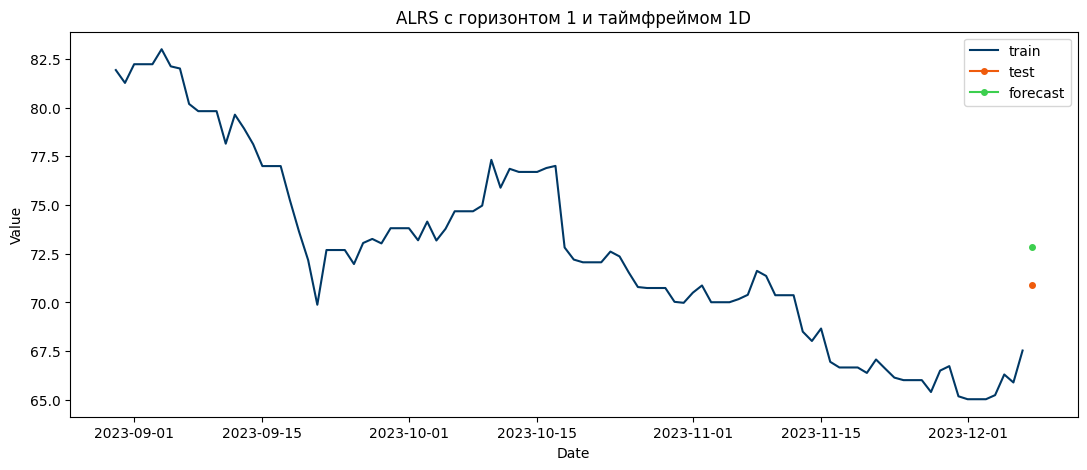

In [18]:
last_N = min(len(train), 100)

fig = plt.figure(figsize=(13, 5))
plt.plot(
    train[DATE_COLUMN][-last_N:], 
    train[TARGET_COLUMN][-last_N:], 
    c="#003865", 
    label="train"
)
plt.plot(
    test[DATE_COLUMN], 
    test[TARGET_COLUMN], 
    c="#EF5B0C", 
    label="test", 
    marker="o", 
    markersize=4
)
plt.plot(
    test[DATE_COLUMN], 
    forecast, 
    c="#3CCF4E", 
    label="forecast", 
    marker="o", 
    markersize=4
)

plt.xlabel("Date")
plt.ylabel("Value")
plt.title(f"{ticker_name} с горизонтом {HORIZON} и таймфреймом {period}")
plt.legend()
plt.show()

In [24]:
result = [{
        "ticker": ticker_name,
        "predict_price": str(forecast[-1]),
        "predict_profit": str(forecast[-1] / train.close.values[-1] - 1),
        "timeframe": HORIZON
    }]

count = 0
while count<=5:
        try:
            url = f'http://213.171.14.97:8080//api/v1/leaderboard/RemoveByDateAndTicker?ticker={ticker_name}&date={datetime.date.today()}'
            response = requests.delete(url)
            if response.status_code == 200:
                print(f"Запрос успешно отправлен")
                break
        except Exception as err:
            print("Ошибка отправка запроса на API:")

        count += 1
        if count == 5:
            print("Ошибка отправка запроса на API:")

count = 0
while count<=5:
        try:
            url = 'http://213.171.14.97:8080/api/v1/leaderboard'
            response = requests.post(url, json=result)
            if response.status_code == 200:
                print(f"Запрос успешно отправлен: {ticker_name}, {forecast[-1] / train.close.values[-1] - 1}")
                break
        except Exception as err:
            print("Ошибка отправка запроса на API:")

        count += 1
        if count == 5:
            print("Ошибка отправка запроса на API:")

Ошибка отправка запроса на API:
Запрос успешно отправлен: ALRS, 0.07845677528737216


In [ ]:
# tickers_test = ['LKOH', 'ROSN', 'AFLT', 'ALRS', 'MGNT', 'MOEX', 'YNDX', 'NLMK', 'PLZL', 'TATN', 'PHOR']
# dates = ['1', '5']
# ad_price = 0
# for d in dates:
#     while ad_price <6:
#         ad_price += 1
#         for i in tickers_test:
#             result =  [{
#                 "ticker": i,
#                 "predict_price": str(ad_price),
#                 "predict_profit": str(ad_price),
#                 "timeframe": d
#             }]
        
#             count = 0
#             while True:
#                 try:
#                     url = 'http://213.171.14.97:8080/api/v1/leaderboard'
#                     response = requests.post(url, json=result)
#                     if response.status_code == 200:
#                         print("Запрос успешно отправлен:")
#                         break
#                 except Exception as err:
#                     print("Ошибка отправка запроса на API:", err)
            
#                 # Делаем повторные попытки в случае ошибки
#                 if count >= 5:
#                     break
            
#                 count += 1